In [15]:
%reload_ext autoreload
import os
curr_dir = "/home/mushaikh/private/PointCloudPosePrediction"
os.chdir(curr_dir)
# os.chdir("/Users/mustafa/Documents/grad school/spring 2024/ECE285 - Visual Learning/PointCloudPosePrediction")
import importlib
import time
from utils.utils import invert_pose
import numpy as np
import transforms3d
from transforms3d.quaternions import mat2quat
import torch
import torch.nn as nn
import torch.nn as nn
from torch.autograd import Variable
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.autograd import Variable
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as transforms
import open3d as o3d
from scipy.io import loadmat
from scipy.spatial.transform import Rotation as R
from tqdm import tqdm
from typing import Any, Callable, Optional, Tuple
import yaml
import cv2
import matplotlib.pyplot as plt
import core.pointnet as pnet
import core.deep_pose_estimator as dpe
import utils.dataloader
import utils.utils
import utils.vision
importlib.reload(dpe)
importlib.reload(pnet)
importlib.reload(utils.utils)
importlib.reload(utils.vision)
importlib.reload(utils.dataloader)

<module 'utils.dataloader' from '/home/mushaikh/private/PointCloudPosePrediction/utils/dataloader.py'>

In [16]:
# run data loader
run_num = 4
data_set_num = 100

# load params for current model run; choose model run below after creating yaml file for it
with open("./models/run_{x}/run_{x}.yaml".format(x=run_num)) as f:
    params = yaml.safe_load(f)

dataset= utils.dataloader.EdenDataset("/home/mushaikh/private/sample",
                                            keypt_method=params['keypoint_detection']['detection_method'],
                                            pcd_num_pts=params['keypoint_detection']['pcd_num_pts']
                                            )

edenLoader = DataLoader(dataset, batch_size=64, shuffle=True, num_workers=1)

In [7]:
USE_GPU = True

if USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
    
    
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)
else:
    torch.manual_seed(42)

In [9]:
model = dpe.DeepPoseEstimator(num_pts=2000, use_pca=True)
model.load_state_dict(torch.load('./models/run_4/run_4_deep_pose_9.pth'))
model.eval()

DeepPoseEstimator(
  (pcd_feat): PointNetFeatureExtractor(
    (feat): PointNetfeat(
      (stn): STN3d(
        (conv1): Conv1d(3, 64, kernel_size=(1,), stride=(1,))
        (conv2): Conv1d(64, 128, kernel_size=(1,), stride=(1,))
        (conv3): Conv1d(128, 1024, kernel_size=(1,), stride=(1,))
        (fc1): Linear(in_features=1024, out_features=512, bias=True)
        (fc2): Linear(in_features=512, out_features=256, bias=True)
        (fc3): Linear(in_features=256, out_features=9, bias=True)
        (relu): ReLU()
        (bn1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (bn3): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (bn4): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (bn5): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=Tru

In [17]:
positions = np.zeros((500, 3))
for j in range(100):
    positions[j] = invert_pose(dataset[j]['pose'])[:3,3] # ground truth poses 

iteration 0
iteration 10
iteration 20
iteration 30
iteration 40
iteration 50
iteration 60
iteration 70
iteration 80
iteration 90


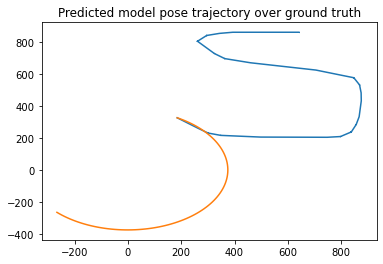

In [18]:
# testing model trajectory
model.to(device)

poses = np.zeros((4, 4, data_set_num))
poses_pred = np.zeros((4, 4, data_set_num))
poses[:, :, 0] = invert_pose(dataset[0]['pose']) # Pose of the robot in body frame at time t = 0
poses[:, :, 0][:3, 3] = poses[:, :, 0][:3, 3] * 100


# saving predicted positions and orientation

p = np.zeros((data_set_num, 3))
q = np.zeros((data_set_num, 4))


for i in range(data_set_num - 1):
    
    if i % 10 == 0:
        print("iteration", i)
    
    pose_pred = np.zeros((4, 4)) # make an empty predicted pose from model

    
    # get the point clous from the dataset
    pcd1, pcd2 = dataset[i]["pcd1"], dataset[i]["pcd2"]
    pcd1, pcd2 = pcd1.transpose(1,0).unsqueeze(0), pcd2.transpose(1,0).unsqueeze(0)
    pcd1, pcd2 = pcd1.to(device), pcd2.to(device) # move
    pred, _, _ = model(pcd1, pcd2)
    

    # convert pred to cpu
    pred = pred.detach().cpu().numpy()[0]
    pos_pred = pred[:3] # get position
    quat_pred = pred[3:] # get quaternion


    # flip quat format such that q = qw qx qy qz
    new_quat_pred = np.zeros((4))
    new_quat_pred[0] = quat_pred[3]
    new_quat_pred[1] = quat_pred[0]
    new_quat_pred[2] = quat_pred[1]
    new_quat_pred[3] = quat_pred[2]
    
    # save position and quaternion prediction
    p[i, :] = pos_pred
    q[i, :] = new_quat_pred
    # 
    
    poses_pred[:, :, i][0:3, 0:3] = transforms3d.quaternions.quat2mat(new_quat_pred)
    poses_pred[:, :, i][:3, 3] = pos_pred
       
        
    poses[:, :, i + 1] = np.matmul(poses_pred[:, :, i], poses[:, :, i]) # world to body pose
    
    
    

# plot
plt.plot(positions[:data_set_num,0] * 100,positions[:data_set_num,1] * 100)
plt.plot(poses[0, -1, :], poses[1, -1, :])
plt.title("Predicted model pose trajectory over ground truth")
plt.show()

In [19]:
# prepare data for evo visualization

mat_est = np.zeros((data_set_num, 8))
mat_gt = np.zeros((data_set_num, 8))
for i in range(data_set_num):
    
    
    # quat from poses pred
    new_quat = np.zeros((4))
    quat = mat2quat(poses[:, :, i][0:3, 0:3])
    new_quat[0] = quat[1]
    new_quat[1] = quat[2]
    new_quat[2] = quat[3]
    new_quat[3] = quat[0]


    mat_est[i, :] = np.append(i, np.append(poses[:, :, i][:3, 3], new_quat))
    mat_gt[i, :] = np.append(i, np.append(invert_pose(dataset[i]['pose'])[:3, 3] * 100, mat2quat(invert_pose(dataset[i]['pose'])[0:3, 0:3])))


filename_est = 'results/stamped_traj_estimate.txt'
filename_gt = 'results/stamped_groundtruth.txt'

# Save the matrix to the text file with the desired format
np.savetxt(filename_est, mat_est, fmt='%.10e', delimiter=' ')
np.savetxt(filename_gt, mat_gt, fmt='%.10e', delimiter=' ')

In [21]:
# run evo_traj for plots for trajectory
evo_traj tum results/plotting_test/stamped_traj_estimate.txt --ref=rpg_trajectory_evaluation/results/plotting_test/stamped_groundtruth.txt -p --plot_mode=xy

/bin/bash: evo_traj: command not found


In [ ]:
# run evo_ape to output data for plotting later
evo_ape tum ./stamped_groundtruth.txt ./stamped_traj_estimate.txt -va --plot --plot_mode xy --save_results ./evo_ape.zip

In [ ]:
# run evo_res for tables, histograms
evo_res evo_ape.zip -p --save_table ./table.csv